# First we are going to experiment with the simulation and see how it performs via NLM
# we are to use euclidean distance between two patches

In [20]:
import numpy as np

def calculate_distance(patch1, patch2):
    """
    Calculate the squared Euclidean distance between two patches.
    """
    return np.sum((patch1 - patch2) ** 2)

def non_local_means(image, patch_size=7, search_window_size=21, h=15.0):
    """
    Apply Non-Local Means denoising algorithm on the given image.
    """
    height, width = image.shape
    padded_image = np.pad(image, patch_size//2, mode='reflect')
    denoised_image = np.zeros_like(image, dtype=np.float64)
    
    for i in range(height):
        for j in range(width):
            i_padded, j_padded = i + patch_size//2, j + patch_size//2
            current_patch = padded_image[i_padded - patch_size//2:i_padded + patch_size//2 + 1,
                                         j_padded - patch_size//2:j_padded + patch_size//2 + 1]
            weighted_sum = 0.0
            total_weight = 0.0
            
            for k in range(max(0, i - search_window_size//2), min(i + search_window_size//2 + 1, height)):
                for l in range(max(0, j - search_window_size//2), min(j + search_window_size//2 + 1, width)):
                    k_padded, l_padded = k + patch_size//2, l + patch_size//2
                    candidate_patch = padded_image[k_padded - patch_size//2:k_padded + patch_size//2 + 1,
                                                   l_padded - patch_size//2:l_padded + patch_size//2 + 1]
                    distance = calculate_distance(current_patch, candidate_patch)
                    weight = np.exp(-distance / (h**2))
                    
                    weighted_sum += weight * image[k, l]
                    total_weight += weight
            
            denoised_image[i, j] = weighted_sum / total_weight if total_weight > 0 else image[i, j]

    return denoised_image

def adjust_parameters_based_on_snr(snr):
    # Example heuristic to estimate sigma from SNR. This needs to be refined
    # based on your application's specific needs and empirical observations.
    # Adjust parameters based on estimated sigma
    if snr > 0:
        sigma_estimated = 100 / snr  # Simplistic estimation; needs refinement
    else:
        sigma_estimated = 50  # Arbitrary high value for extremely low or zero SNR
    if 0 < sigma_estimated <= 15:
        patch_size = 3
        search_window_size = 21
        h = 0.40 * sigma_estimated
    elif 15 < sigma_estimated <= 30:
        patch_size = 5
        search_window_size = 21
        h = 0.40 * sigma_estimated
    elif 30 < sigma_estimated <= 45:
        patch_size = 7
        search_window_size = 35
        h = 0.35 * sigma_estimated
    elif 45 < sigma_estimated <= 75:
        patch_size = 9
        search_window_size = 35
        h = 0.35 * sigma_estimated
    elif 75 < sigma_estimated <= 100:
        patch_size = 11
        search_window_size = 35
        h = 0.30 * sigma_estimated
    else:
        # Default/fallback values for very high sigma
        patch_size = 11
        search_window_size = 35
        h = 0.30 * sigma_estimated
    
    return patch_size, search_window_size, h


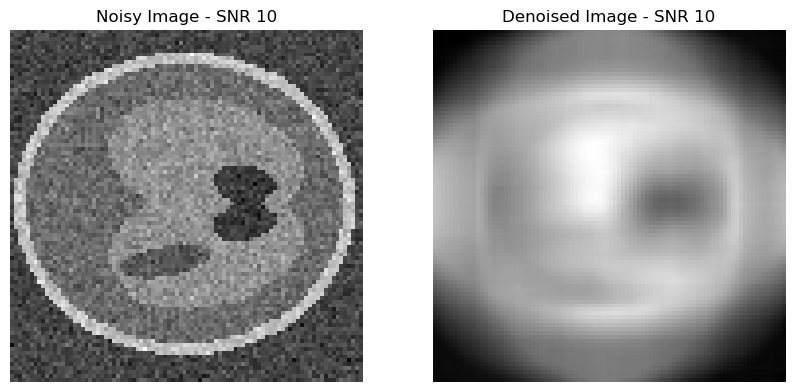

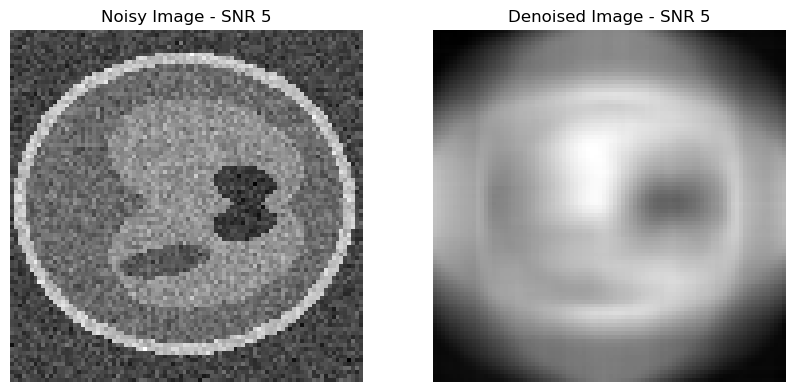

KeyboardInterrupt: 

In [23]:
# Define the specific SNRs to display
snrs = [10, 5, 3, 1, 0]

# Iterate over each SNR
for snr in snrs:
    # Load the MAT file
    mat = scipy.io.loadmat(f'/Users/dolorious/Downloads/simulation-1/GroundTruth_gaussian_SNR{snr}.mat')

    # Check if the image has more than 2 dimensions and select the first channel if it's the case
    if noisy_image.ndim > 2 and noisy_image.shape[2] > 1:
    # This line assumes the image is color and we convert it to grayscale
    # This is a simple way to convert to grayscale, consider using more advanced techniques if needed
       noisy_image = noisy_image.mean(axis=2)
    elif noisy_image.ndim > 2:
    # If the image is already grayscale but still has an extra dimension
         noisy_image = noisy_image


    # Adjust NLM parameters based on SNR
    patch_size, search_window_size, h = adjust_parameters_based_on_snr(snr)
    
    # Apply your custom Non-Local Means Denoising with adjusted parameters
    denoised_image = non_local_means(noisy_image, patch_size=patch_size, search_window_size=search_window_size, h=h)

    # Plot the original noisy image and the denoised image
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(noisy_image, cmap='gray')
    plt.title(f'Noisy Image - SNR {snr}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(denoised_image, cmap='gray')
    plt.title(f'Denoised Image - SNR {snr}')
    plt.axis('off')

    plt.show()


In [45]:
from tarfile import BLOCKSIZE
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import denoise_nl_means, estimate_sigma
import scipy.io

# Define a function to adjust NLM parameters based on the estimated noise level (sigma)
def adjust_denoising_parameters(sigma_est):
    if sigma_est <= 15:
        h = 0.40 * sigma_est  
        patch_size = 3 
        block_size = 21  
    elif sigma_est <= 30:
        h = 0.40 * sigma_est  
        patch_size = 5  
        block_size = 21 
    elif sigma_est <= 45:
        h = 0.35 * sigma_est  
        patch_size = 7  
        block_size = 35  
    elif sigma_est <= 75:
        h = 0.35 * sigma_est  
        patch_size = 9 
        block_size = 35 
    else:  
        h = 0.30 * sigma_est  
        patch_size = 11 
        block_size = 35  
    
    return h, patch_size, block_size


# Iterate over each SNR
for snr in [10, 5, 3, 1, 0]:
    # Load the image data
    mat = scipy.io.loadmat(f'/Users/dolorious/Downloads/simulation-1/GroundTruth_gaussian_SNR{snr}.mat')
    noisy_image = mat['data_gaussian']  # Update the key accordingly

    # Estimate sigma from the noisy image
    sigma_est = np.mean(estimate_sigma(noisy_image, multichannel=False))

    # Adjust NLM parameters based on the estimated sigma
    patch_size, patch_distance, h = adjust_denoising_parameters(sigma_est)

    # Apply NLM denoising
    denoised_image = denoise_nl_means(noisy_image, h=h, patch_size=patch_size, block_size=BLOCKSIZE, multichannel=True)

    # Visualization
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(noisy_image, cmap='gray')
    plt.title(f'Noisy Image - SNR {snr}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(denoised_image, cmap='gray')
    plt.title('Denoised Image')
    plt.axis('off')

    plt.show()


/var/folders/vl/tld4y4295dvbpfhgzk8mrvkc0000gn/T/ipykernel_50687/1019658247.py:40: FutureWarning: `multichannel` is a deprecated argument name for `estimate_sigma`. It will be removed in version 1.0. Please use `channel_axis` instead.
  sigma_est = np.mean(estimate_sigma(noisy_image, multichannel=False))
/Users/dolorious/opt/anaconda3/lib/python3.9/site-packages/skimage/_shared/utils.py:348: UserWarning: image is size 3 on the last axis, but channel_axis is None. If this is a color image, please set channel_axis=-1 for proper noise estimation.
  return func(*args, **kwargs)
/var/folders/vl/tld4y4295dvbpfhgzk8mrvkc0000gn/T/ipykernel_50687/1019658247.py:46: FutureWarning: `multichannel` is a deprecated argument name for `denoise_nl_means`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoised_image = denoise_nl_means(noisy_image, h=h, patch_size=patch_size, block_size=BLOCKSIZE, multichannel=True)


TypeError: denoise_nl_means() got an unexpected keyword argument 'block_size'

/var/folders/vl/tld4y4295dvbpfhgzk8mrvkc0000gn/T/ipykernel_50687/314181380.py:74: FutureWarning: `multichannel` is a deprecated argument name for `estimate_sigma`. It will be removed in version 1.0. Please use `channel_axis` instead.
  sigma_est = np.mean(estimate_sigma(noisy_image, multichannel=True))


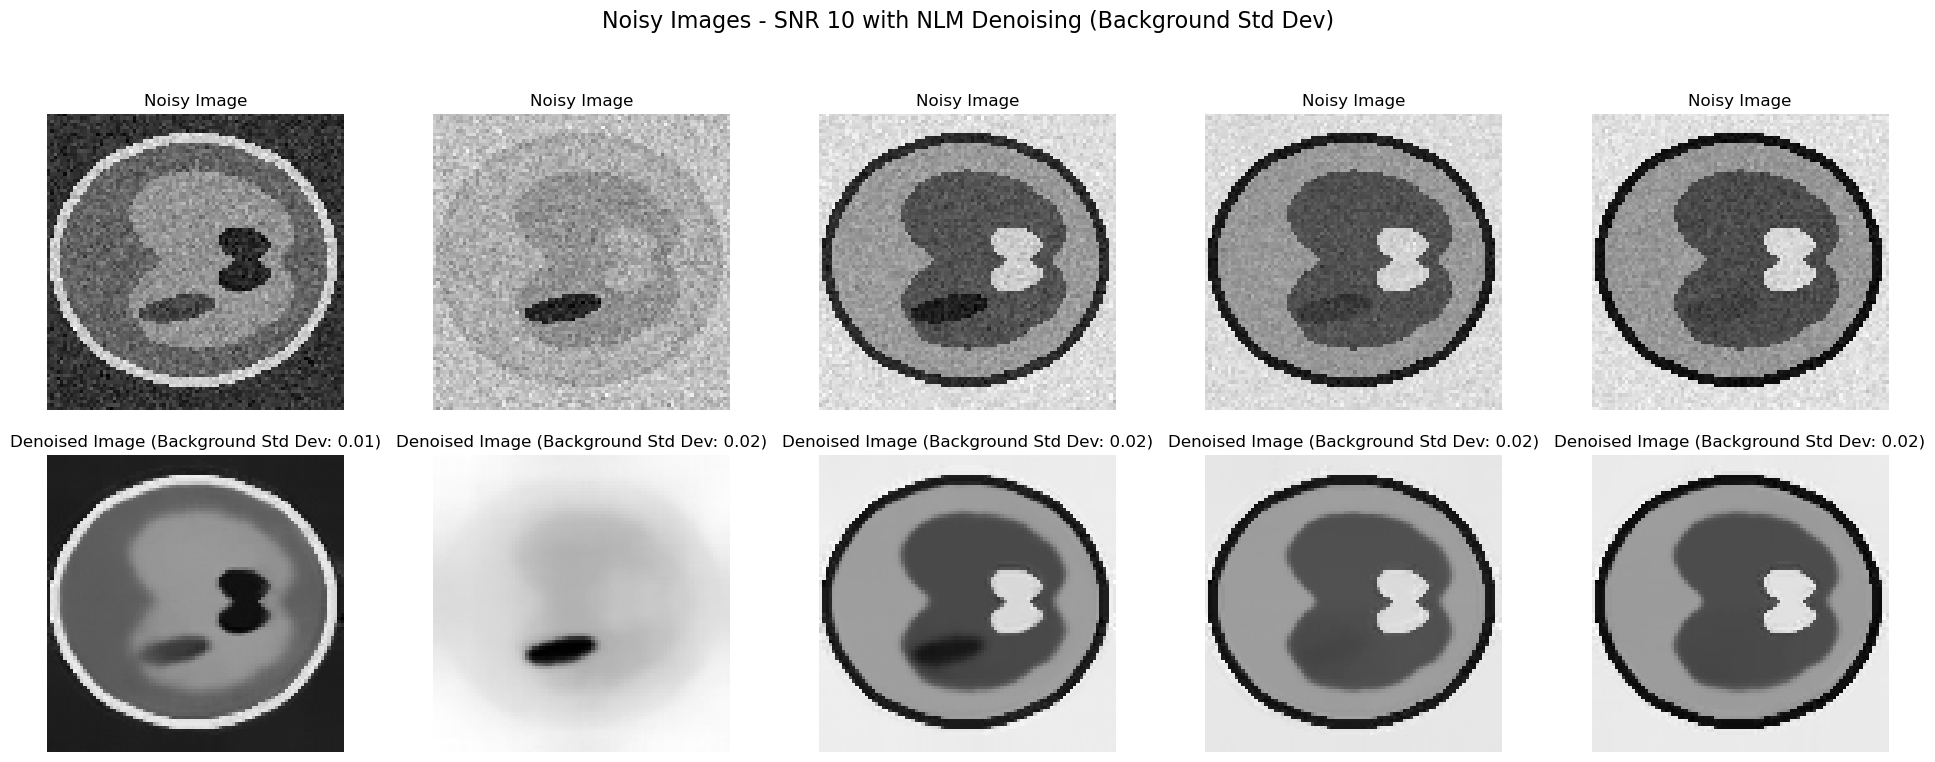

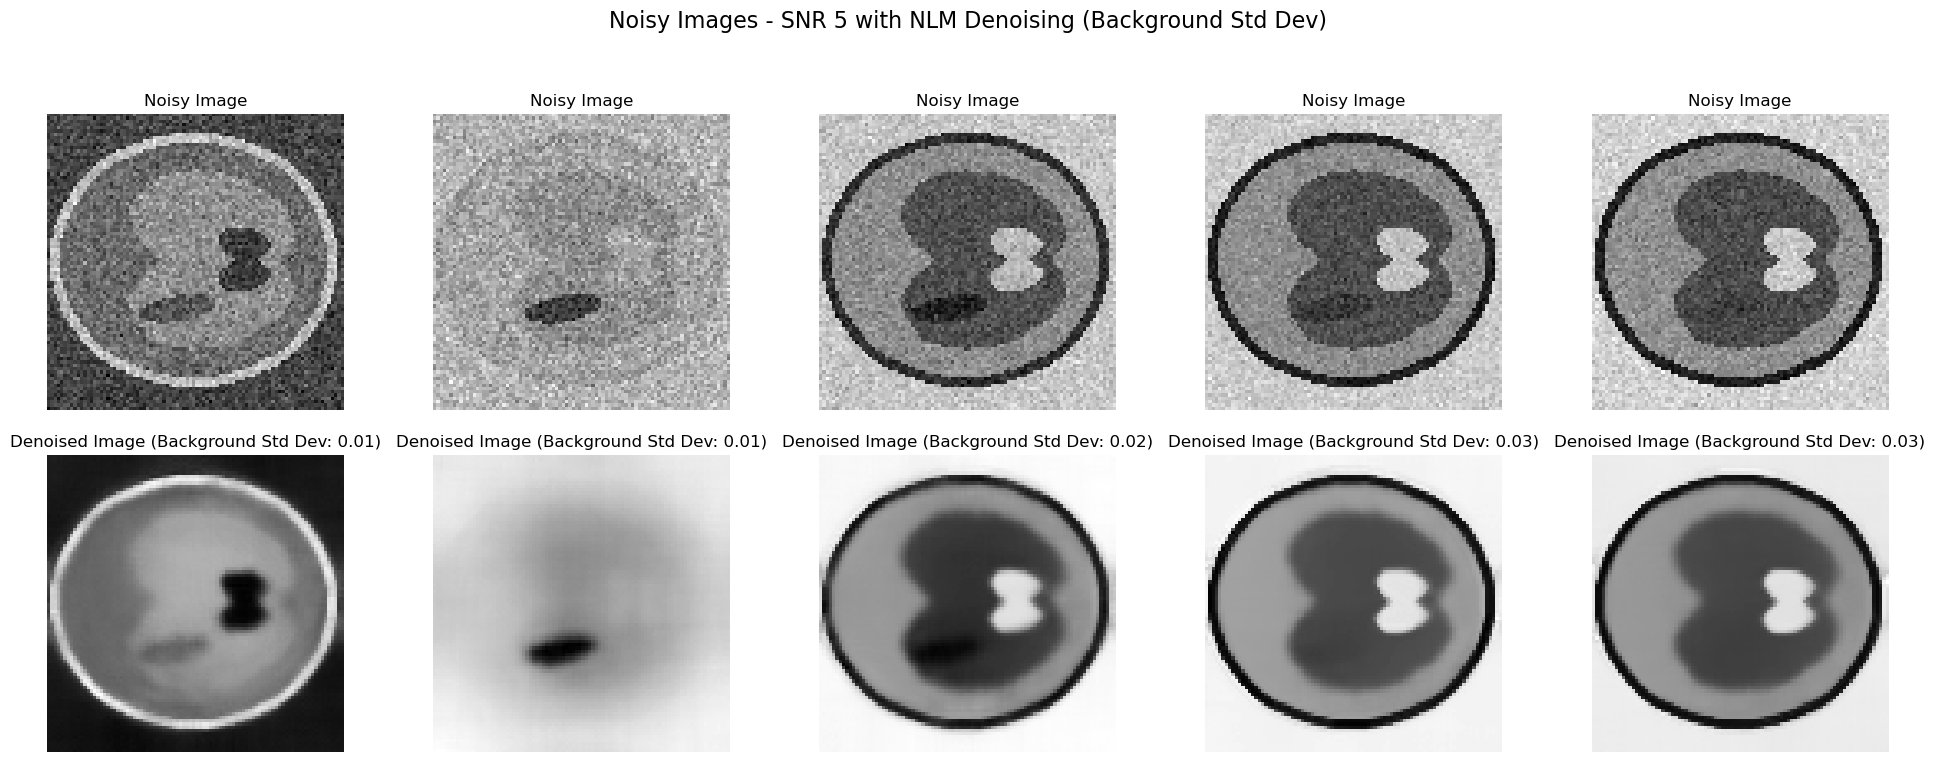

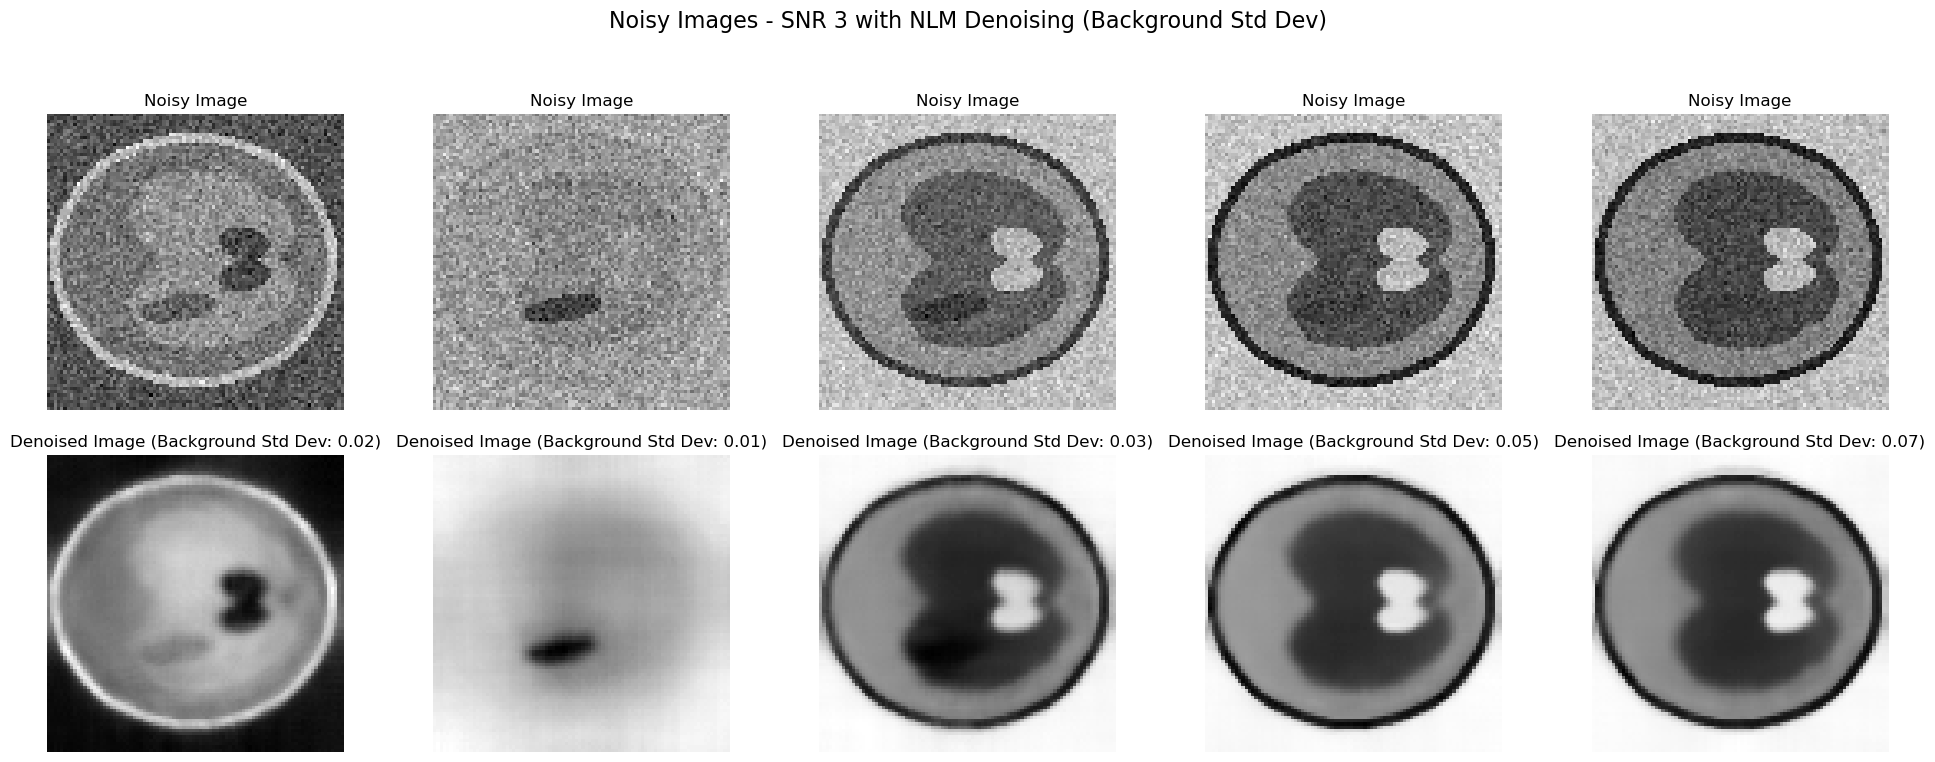

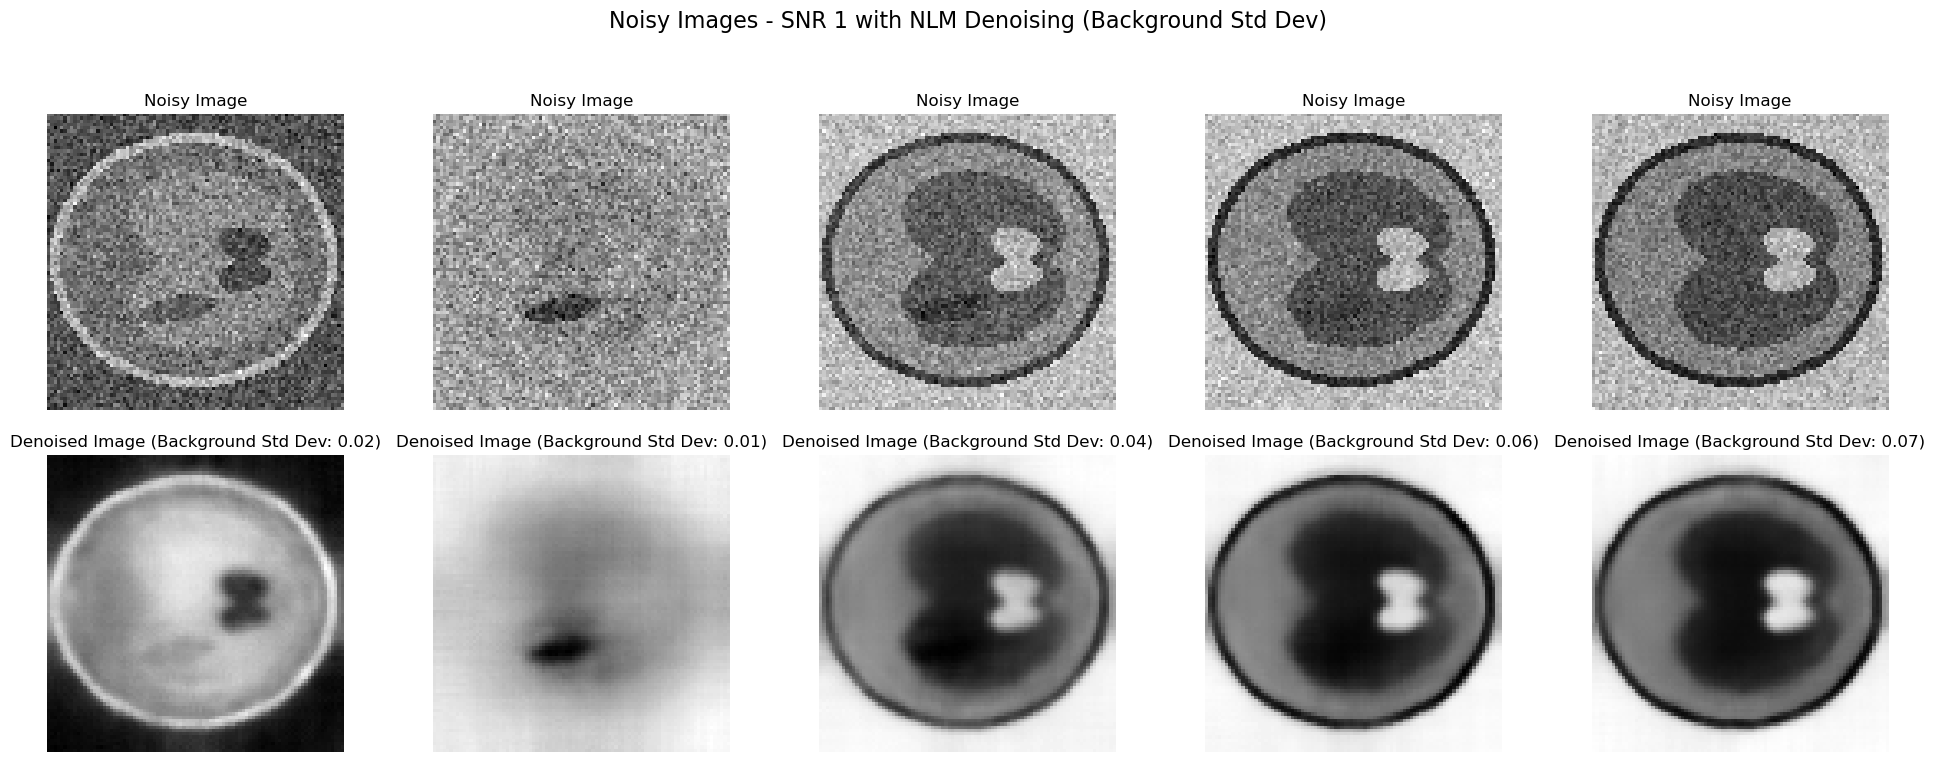

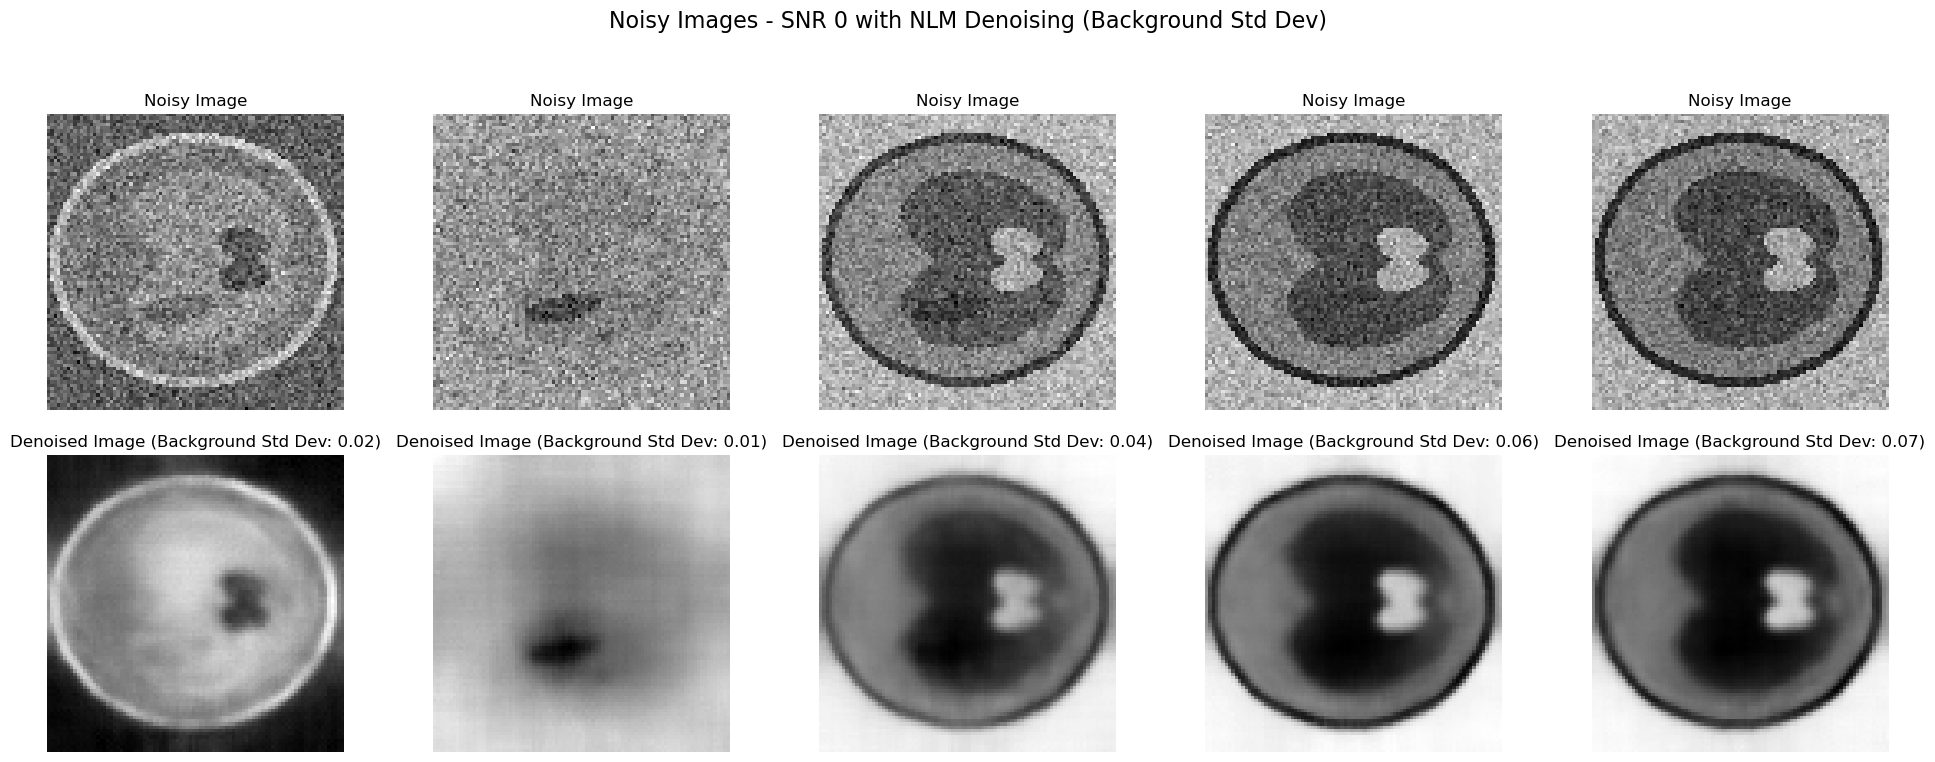

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import estimate_sigma, denoise_nl_means
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
import scipy.io

def create_background_mask(image_gray):
    # Use Otsu's method to automatically determine a threshold for binarization
    thresh = threshold_otsu(image_gray)

    # Binarize the image based on the determined threshold
    binary_image = image_gray <= thresh

    # Remove small objects and clear borders
    cleared_image = clear_border(binary_image)

    # Label connected components
    label_image = label(cleared_image)

    # Find properties of labeled regions
    regions = regionprops(label_image)

    # Find the largest region (assuming it's the background)
    largest_area = 0
    background_label = 0
    for region in regions:
        if region.area > largest_area:
            largest_area = region.area
            background_label = region.label

    # Create a mask for the background region
    background_mask = label_image == background_label

    return background_mask

# Define the specific SNRs to display
snrs = [10, 5, 3, 1, 0]  

def adjust_denoising_parameters(sigma_est):
    if sigma_est <= 15:
        return 0.6 * sigma_est, 7, 11  # h, patch_size, patch_distance
    elif sigma_est <= 30:
        return 0.9 * sigma_est, 5, 6
    elif sigma_est <= 50:
        return 0.2 * sigma_est, 9, 17
    else:
        return 0.4 * sigma_est, 11, 23

# Iterate over each SNR
for snr in snrs:
    # Load the MAT file
    mat = scipy.io.loadmat(f'/Users/dolorious/Downloads/simulation-1/GroundTruth_gaussian_SNR{snr}.mat')

    # Extract noisy image data for the specified SNR
    noisy_image_data = mat['data_gaussian']

    plt.figure(figsize=(20, 8))  # Adjust the figure size as needed.

    conditions = noisy_image_data.shape[2]  # Assuming this represents different conditions.
    for j in range(conditions):
        # Extract the noisy image for the jth condition.
        noisy_image = noisy_image_data[:, :, j].squeeze()
        
        # Check if the image has three channels (RGB), and convert to grayscale if so
        if noisy_image.ndim == 3 and noisy_image.shape[2] == 3:
            noisy_image_gray = noisy_image.mean(axis=2)
        else:
            # If the image is already grayscale or doesn't meet the RGB shape assumption
            noisy_image_gray = noisy_image

        # Estimate the noise standard deviation from the image
        sigma_est = np.mean(estimate_sigma(noisy_image, multichannel=True))

        # Dynamically adjust denoising parameters based on estimated noise level
        h, patch_size, patch_distance = adjust_denoising_parameters(sigma_est)

        # Create a mask to isolate the background
        background_mask = create_background_mask(noisy_image_gray)

        # Calculate the standard deviation of background pixels
        std_deviation = np.std(noisy_image_gray[background_mask])

        # Apply Non-Local Means Denoising with dynamically adjusted parameters
        denoised_image = denoise_nl_means(noisy_image_gray, h=h, patch_size=patch_size,
                                          patch_distance=patch_distance)

        # Plot the original noisy image
        plt.subplot(2, conditions, j + 1)  # 2 rows, N columns, jth subplot
        plt.imshow(noisy_image_gray, cmap='gray')  # Display noisy image in grayscale
        plt.title('Noisy Image')
        plt.axis('off')

        # Plot the denoised image
        plt.subplot(2, conditions, j + conditions + 1)  # 2 rows, N columns, (j+N)th subplot
        plt.imshow(denoised_image, cmap='gray')  # Display denoised image in grayscale
        plt.title(f'Denoised Image (Background Std Dev: {std_deviation:.2f})')
        plt.axis('off')

    # Adjust layout
    plt.tight_layout(pad=3.0, h_pad=3.0, w_pad=1.0)  # Adjust horizontal and vertical padding between subplots

    # Adjust the top margin to make space for the super title
    plt.subplots_adjust(top=0.85)

    # Add a super title and adjust its position
    plt.suptitle(f'Noisy Images - SNR {snr} with NLM Denoising (Background Std Dev)', fontsize=16, y=0.98)

    # Show plot
    plt.show()


In [1]:
 pip install --upgrade pip

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/8a/6a/19e9fe04fca059ccf770861c7d5721ab4c2aebc539889e97c7977528a53b/pip-24.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.8 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1
Note: you may need to restart the kernel to use updated packages.


/var/folders/vl/tld4y4295dvbpfhgzk8mrvkc0000gn/T/ipykernel_50687/386746743.py:74: FutureWarning: `multichannel` is a deprecated argument name for `estimate_sigma`. It will be removed in version 1.0. Please use `channel_axis` instead.
  sigma_est = np.mean(estimate_sigma(noisy_image, multichannel=True))


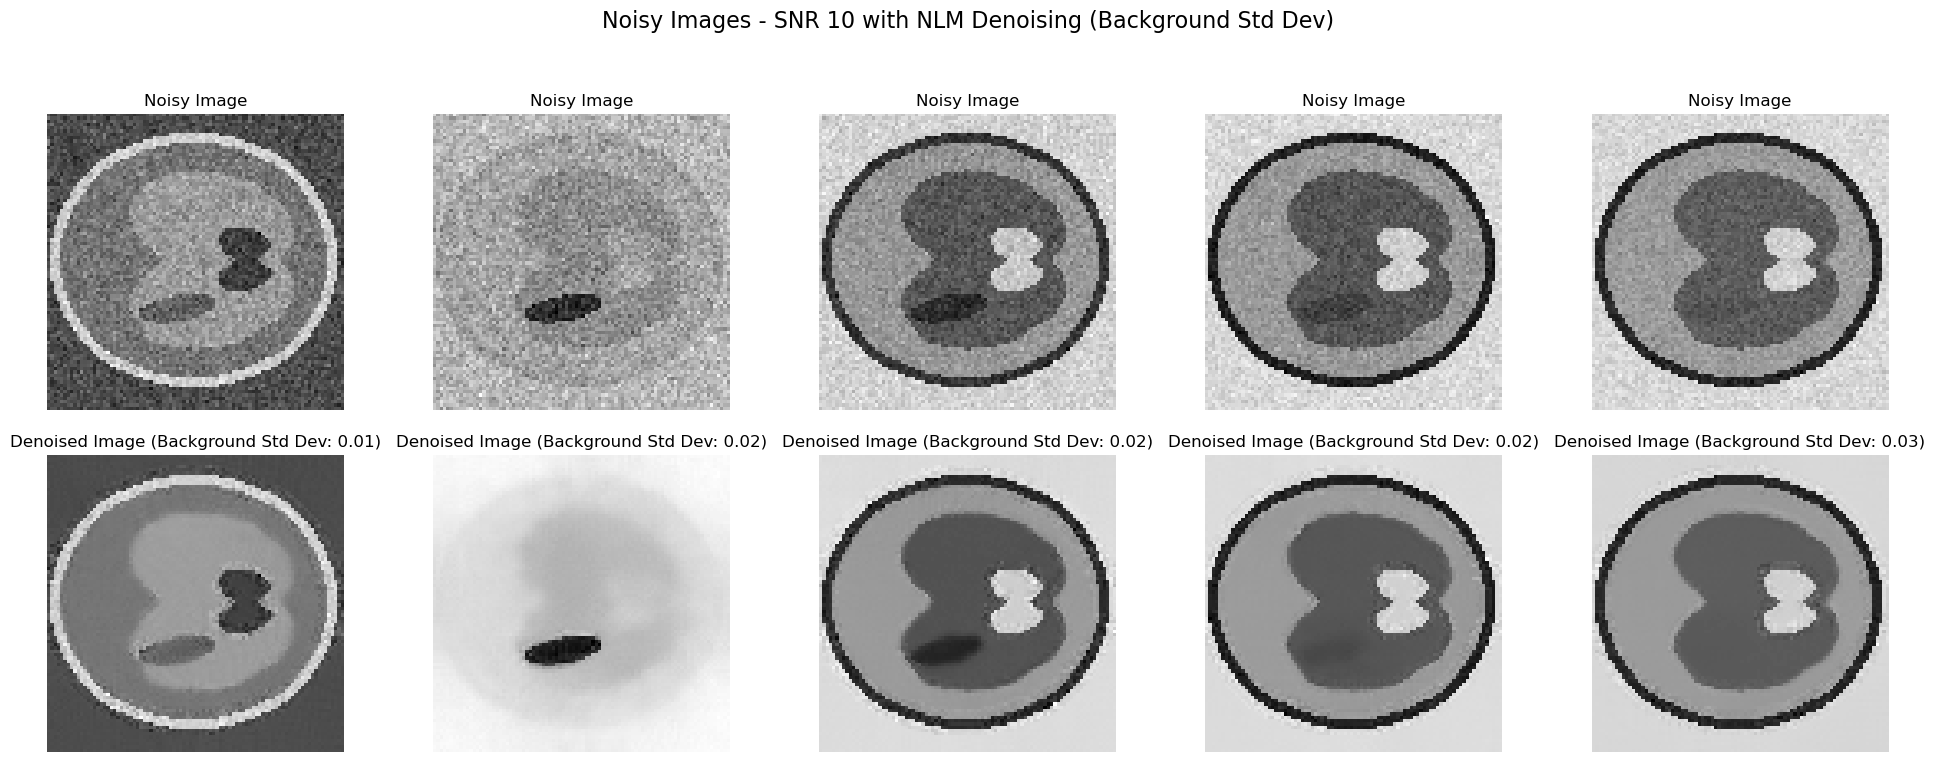

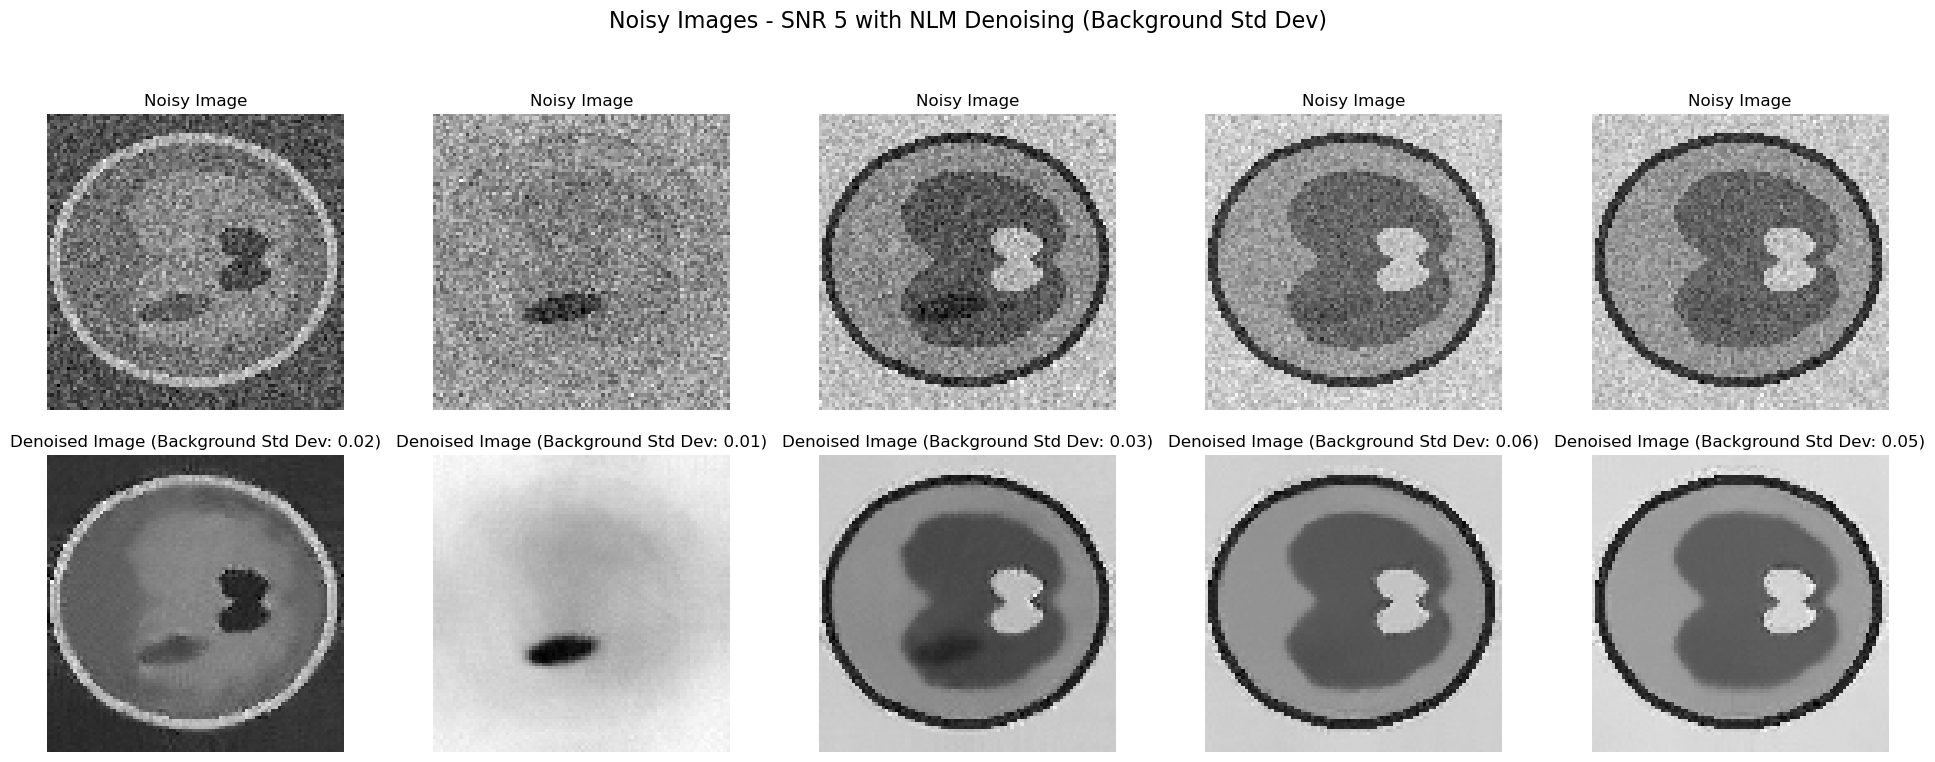

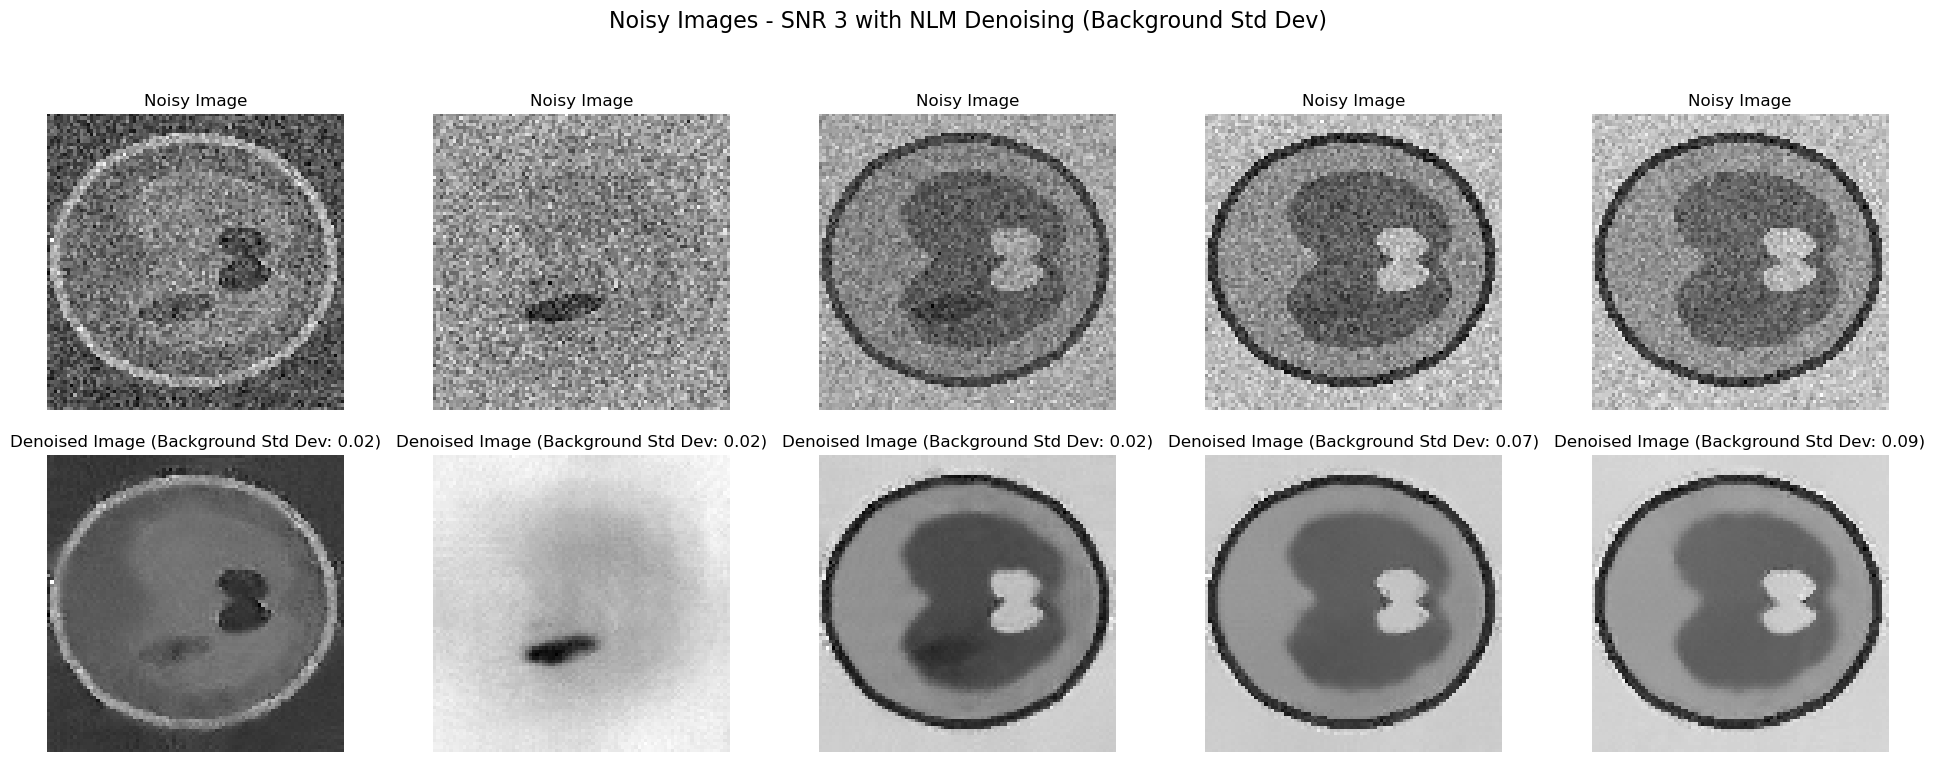

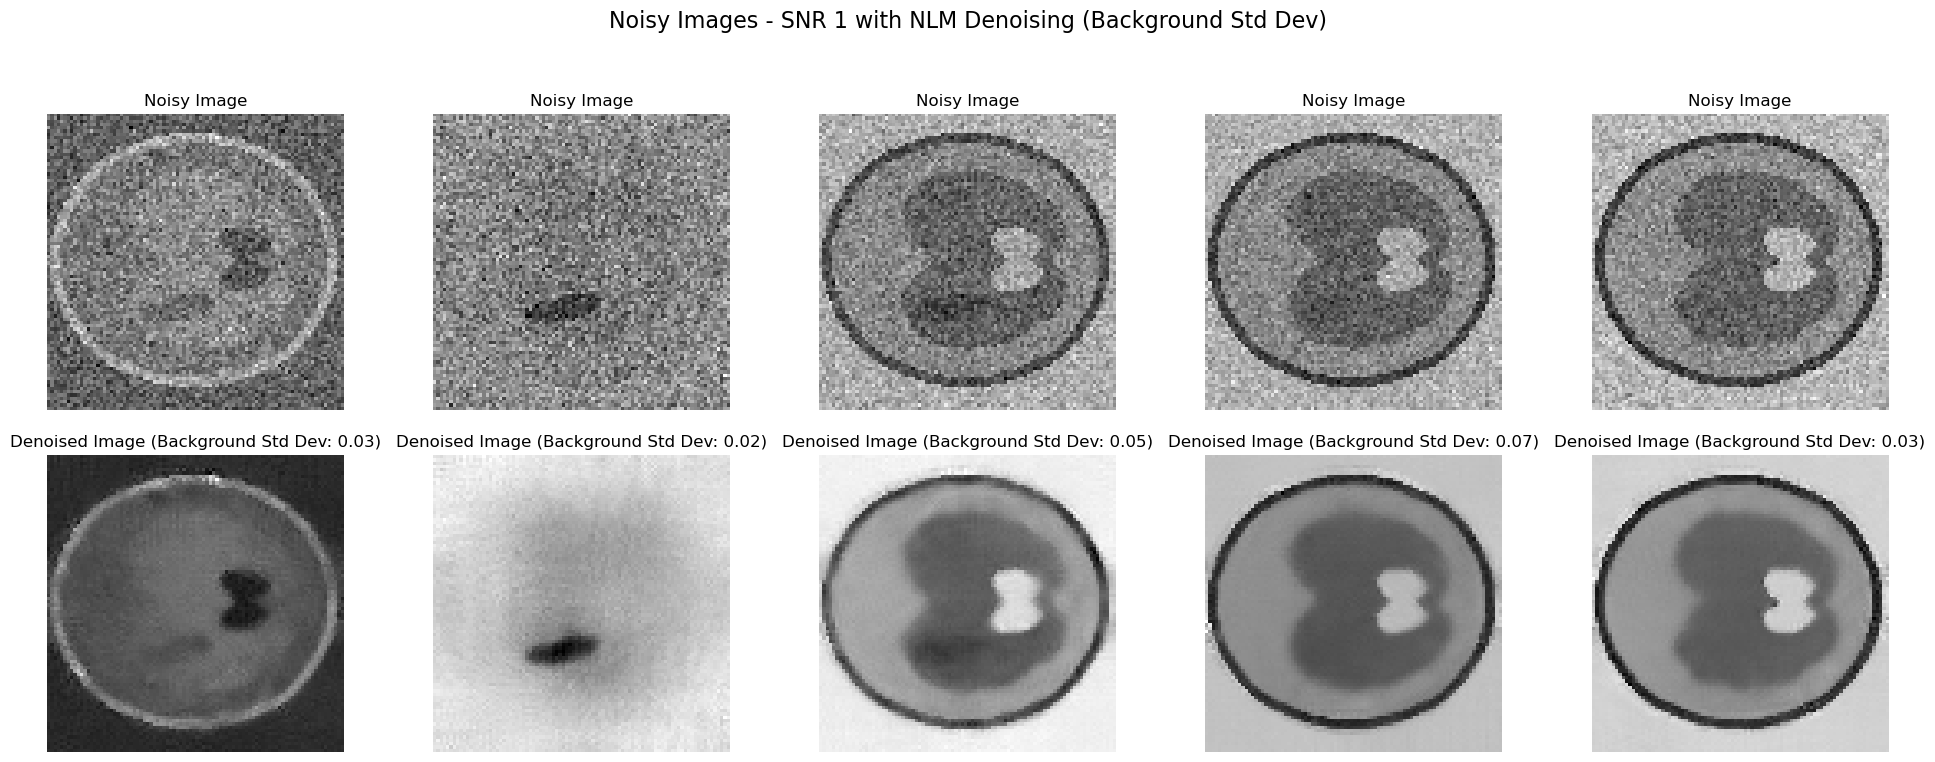

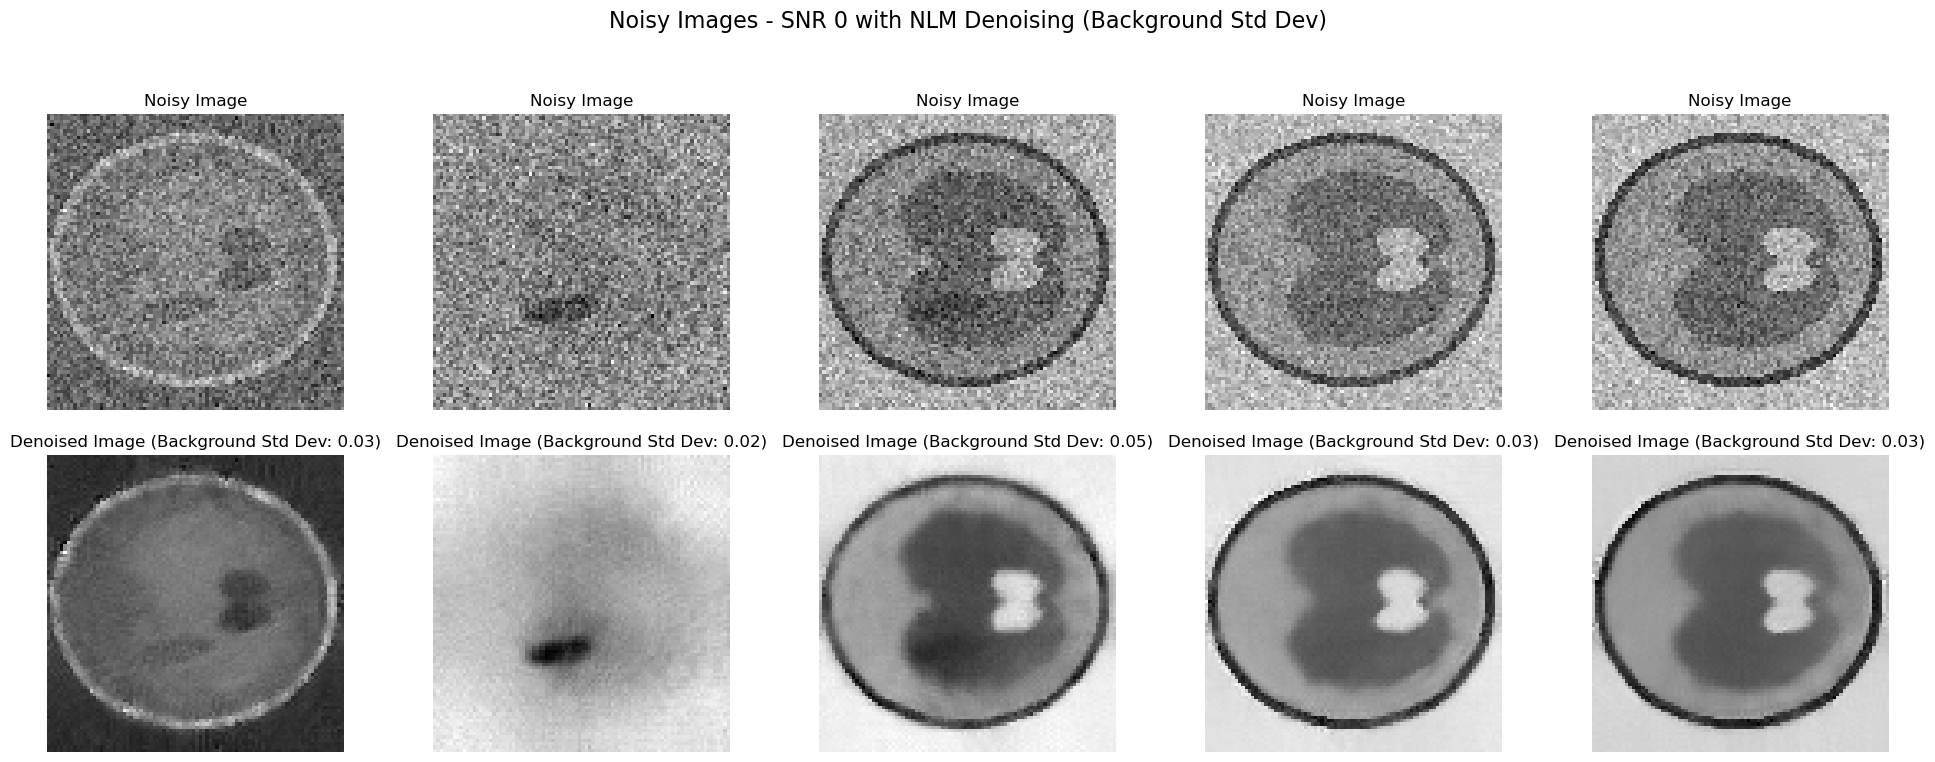

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import estimate_sigma, denoise_nl_means
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
import scipy.io

def create_background_mask(image_gray):
    # Use Otsu's method to automatically determine a threshold for binarization
    thresh = threshold_otsu(image_gray)

    # Binarize the image based on the determined threshold
    binary_image = image_gray <= thresh

    # Remove small objects and clear borders
    cleared_image = clear_border(binary_image)

    # Label connected components
    label_image = label(cleared_image)

    # Find properties of labeled regions
    regions = regionprops(label_image)

    # Find the largest region (assuming it's the background)
    largest_area = 0
    background_label = 0
    for region in regions:
        if region.area > largest_area:
            largest_area = region.area
            background_label = region.label

    # Create a mask for the background region
    background_mask = label_image == background_label

    return background_mask

# Define the specific SNRs to display
snrs = [10, 5, 3, 1, 0]  

def adjust_denoising_parameters(sigma_est):
    if sigma_est <= 15:
        return 0.6 * sigma_est, 7, 11  # h, patch_size, patch_distance
    elif sigma_est <= 30:
        return 0.9 * sigma_est, 5, 6
    elif sigma_est <= 50:
        return 0.2 * sigma_est, 9, 17
    else:
        return 0.4 * sigma_est, 11, 23

# Iterate over each SNR
for snr in snrs:
    # Load the MAT file
    mat = scipy.io.loadmat(f'/Users/dolorious/Downloads/simulation-1/GroundTruth_gaussian_SNR{snr}.mat')

    # Extract noisy image data for the specified SNR
    noisy_image_data = mat['data_gaussian']

    plt.figure(figsize=(20, 8))  # Adjust the figure size as needed.

    conditions = noisy_image_data.shape[2]  # Assuming this represents different conditions.
    for j in range(conditions):
        # Extract the noisy image for the jth condition.
        noisy_image = noisy_image_data[:, :, j].squeeze()
        
        # Check if the image has three channels (RGB), and convert to grayscale if so
        if noisy_image.ndim == 3 and noisy_image.shape[2] == 3:
            noisy_image_gray = noisy_image.mean(axis=2)
        else:
            # If the image is already grayscale or doesn't meet the RGB shape assumption
            noisy_image_gray = noisy_image

        # Estimate the noise standard deviation from the image
        sigma_est = np.mean(estimate_sigma(noisy_image, multichannel=True))

        # Dynamically adjust denoising parameters based on estimated noise level
        h, patch_size, patch_distance = adjust_denoising_parameters(sigma_est)

        # Create a mask to isolate the background
        background_mask = create_background_mask(noisy_image_gray)

        # Calculate the standard deviation of background pixels
        std_deviation = np.std(noisy_image_gray[background_mask])

        # Apply Non-Local Means Denoising with dynamically adjusted parameters
        denoised_image = denoise_nl_means(noisy_image_gray, h=h, patch_size=patch_size,
                                          patch_distance=patch_distance)

        # Plot the original noisy image
        plt.subplot(2, conditions, j + 1)  # 2 rows, N columns, jth subplot
        plt.imshow(noisy_image_gray, cmap='gray')  # Display noisy image in grayscale
        plt.title('Noisy Image')
        plt.axis('off')

        # Plot the denoised image
        plt.subplot(2, conditions, j + conditions + 1)  # 2 rows, N columns, (j+N)th subplot
        plt.imshow(denoised_image, cmap='gray')  # Display denoised image in grayscale
        plt.title(f'Denoised Image (Background Std Dev: {std_deviation:.2f})')
        plt.axis('off')

    # Adjust layout
    plt.tight_layout(pad=3.0, h_pad=3.0, w_pad=1.0)  # Adjust horizontal and vertical padding between subplots

    # Adjust the top margin to make space for the super title
    plt.subplots_adjust(top=0.85)

    # Add a super title and adjust its position
    plt.suptitle(f'Noisy Images - SNR {snr} with NLM Denoising (Background Std Dev)', fontsize=16, y=0.98)

    # Show plot
    plt.show()



/var/folders/vl/tld4y4295dvbpfhgzk8mrvkc0000gn/T/ipykernel_50687/3083674192.py:36: FutureWarning: `multichannel` is a deprecated argument name for `denoise_nl_means`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoised_image = denoise_nl_means(noisy_image, h=1.15 * sigma_est, fast_mode=True,
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


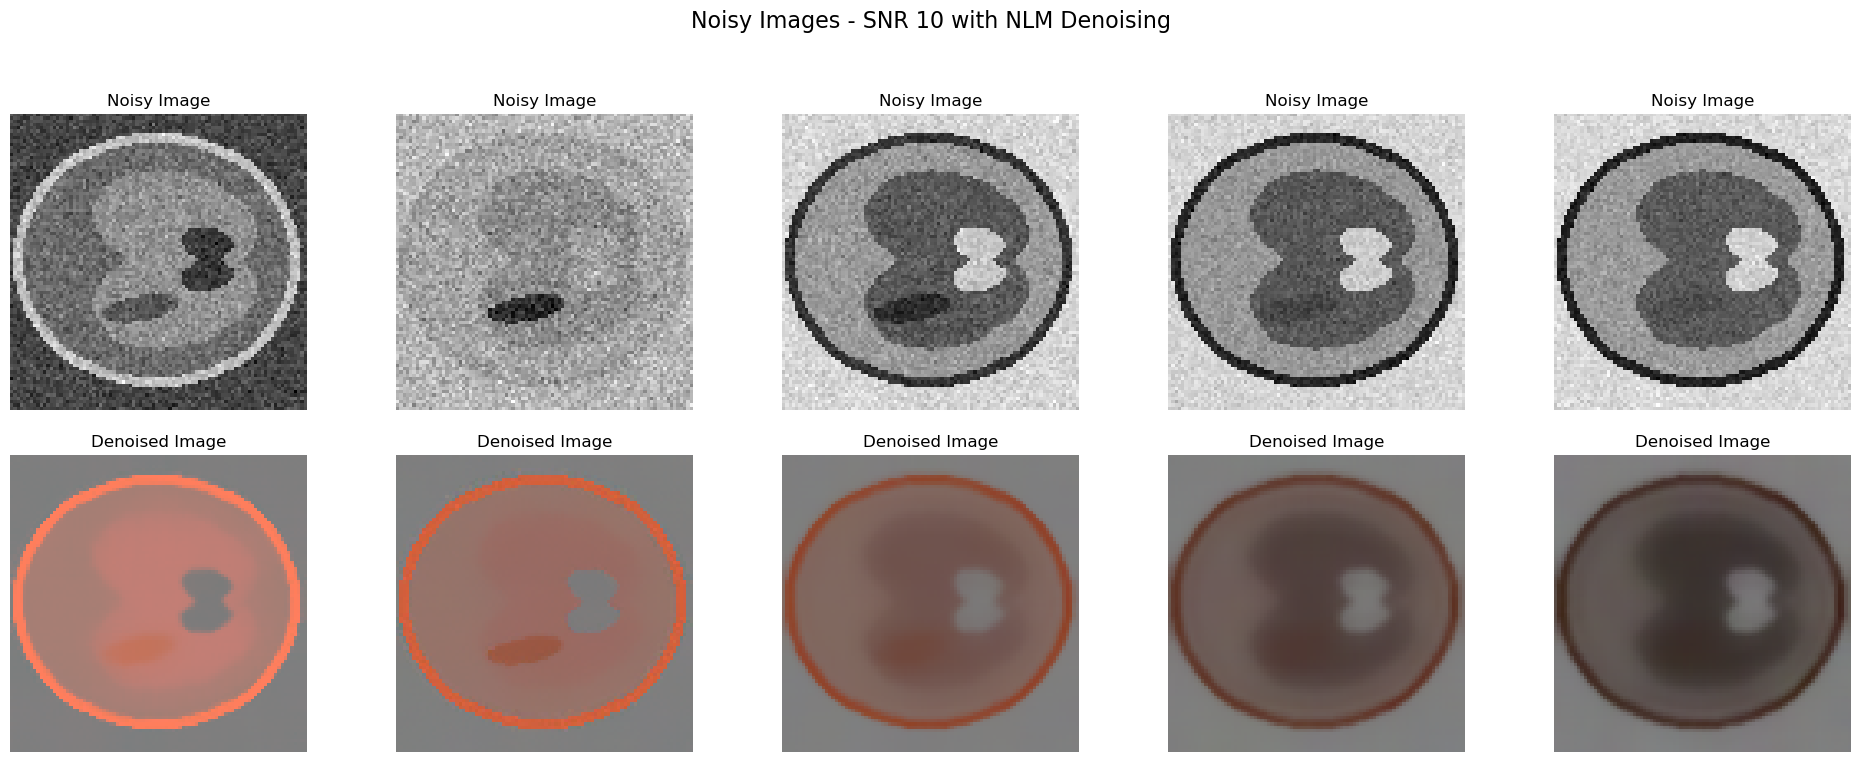

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


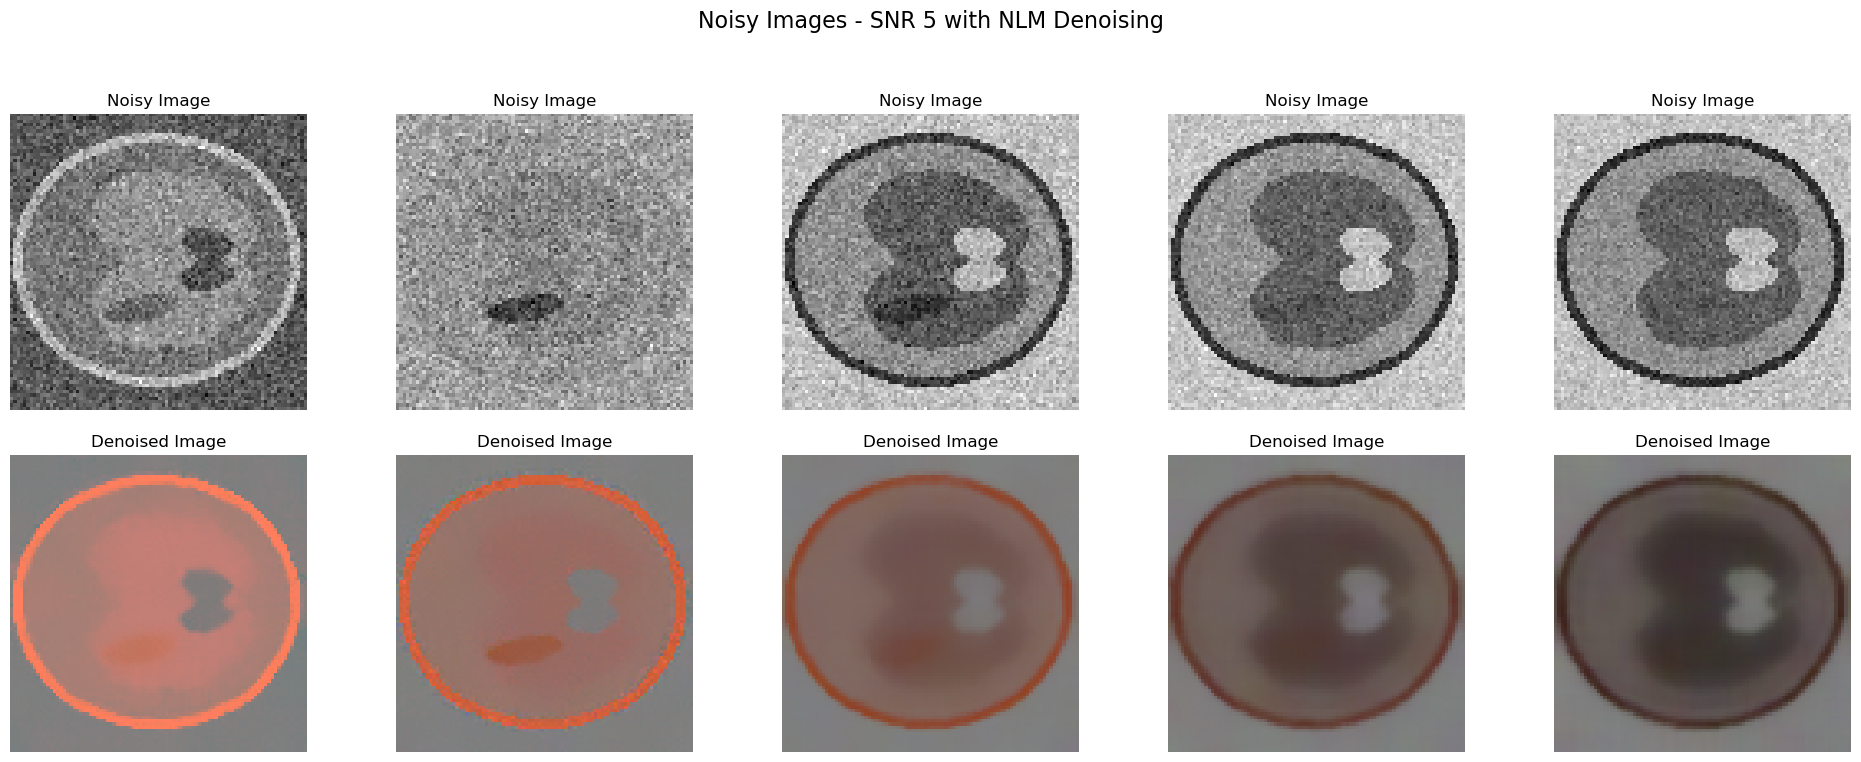

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


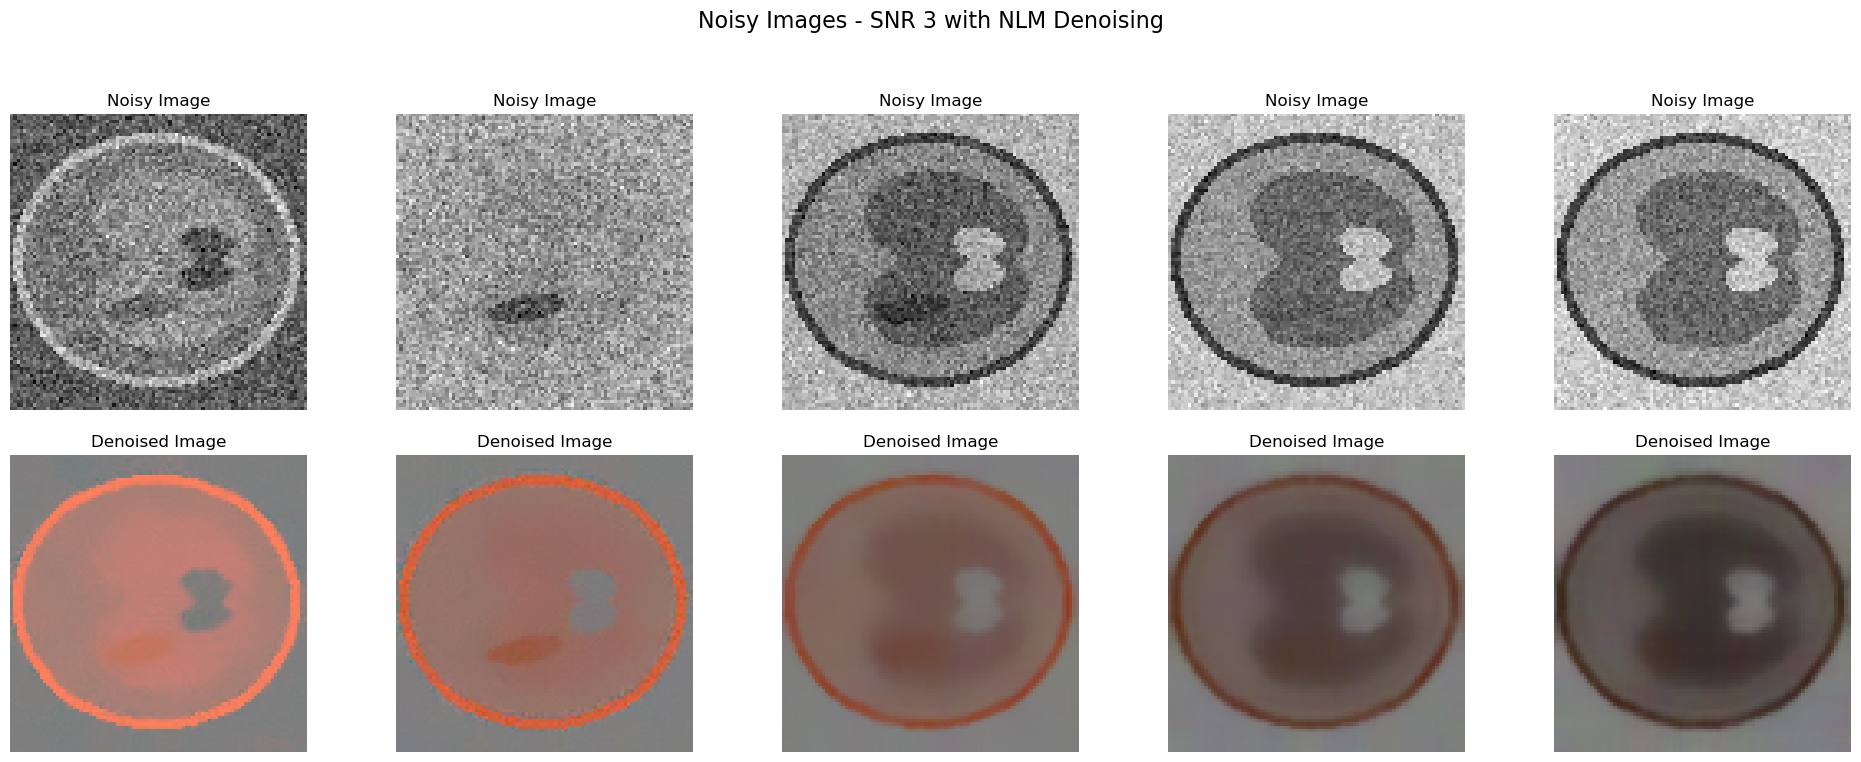

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


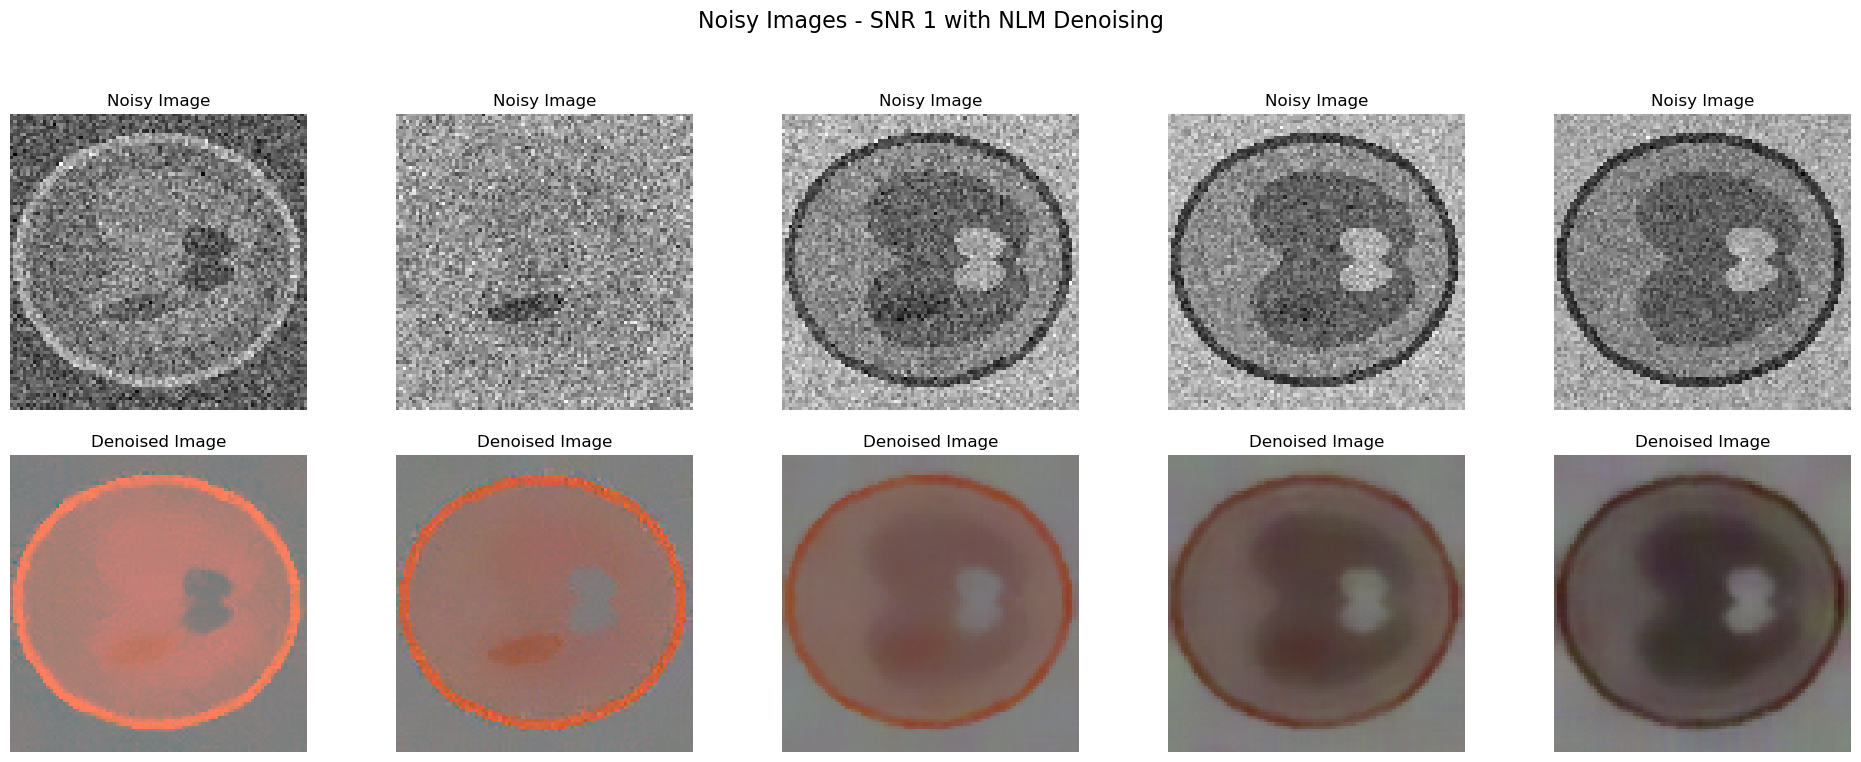

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


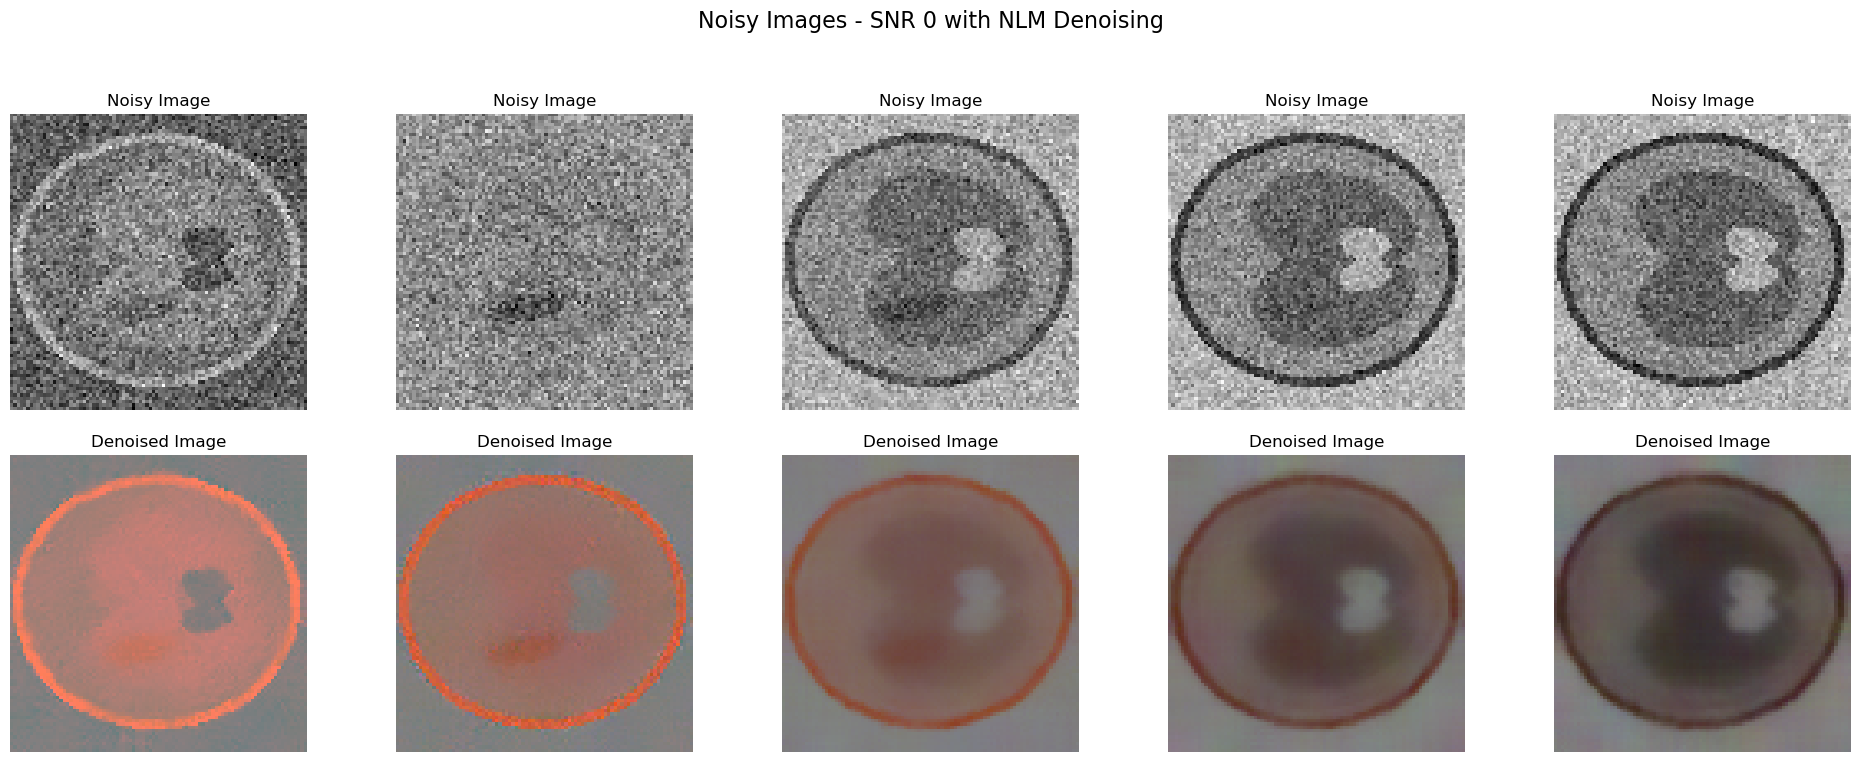

In [8]:
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
from skimage.restoration import estimate_sigma, denoise_nl_means

# Define the specific SNRs to display
snrs = [10, 5, 3, 1, 0]  

# Iterate over each SNR
for snr in snrs:
    # Load the MAT file
    mat = scipy.io.loadmat(f'/Users/dolorious/Downloads/simulation-1/GroundTruth_gaussian_SNR{snr}.mat')

    # Extract noisy image data for the specified SNR
    noisy_image_data = mat['data_gaussian']

    plt.figure(figsize=(20, 8))  # Adjust the figure size as needed.

    conditions = noisy_image_data.shape[2]  # Assuming this represents different conditions.

    for j in range(conditions):
        noisy_image = noisy_image_data[:, :, j]
        
        # Check if the image has three channels (RGB), and convert to grayscale if so
        if noisy_image.ndim == 3 and noisy_image.shape[2] == 3:
            noisy_image_gray = np.mean(noisy_image, axis=2)
        else:
            noisy_image_gray = noisy_image  # The image is already grayscale
        
        # Estimate the noise standard deviation using the noisy image
        sigma_est = np.std(noisy_image_gray)

        # Apply Non-Local Means Denoising with appropriate `multichannel` flag based on image type
        if noisy_image.ndim == 3 and noisy_image.shape[2] == 3:
            # For RGB images, keep `multichannel=True`
            denoised_image = denoise_nl_means(noisy_image, h=1.15 * sigma_est, fast_mode=True,
                                              patch_size=5, patch_distance=6, multichannel=True)
            # Convert denoised RGB to grayscale for consistent plotting
            denoised_image_gray = np.mean(denoised_image, axis=2)
        else:
            # For grayscale images, use `multichannel=False`
            denoised_image_gray = denoise_nl_means(noisy_image_gray, h=1.15 * sigma_est, fast_mode=True,
                                                   patch_size=5, patch_distance=6, multichannel=False)

        # Plot the original noisy image
        plt.subplot(2, conditions, j + 1)  # 2 rows, N columns, jth subplot
        plt.imshow(noisy_image_gray, cmap='gray')  # Display noisy image in grayscale
        plt.title('Noisy Image')
        plt.axis('off')

        # Plot the denoised image
        plt.subplot(2, conditions, j + conditions + 1)  # 2 rows, N columns, (j+N)th subplot
        plt.imshow(denoised_image, cmap='gray')  # Display denoised image in grayscale
        plt.title('Denoised Image')
        plt.axis('off')

    # Adjust layout
    plt.tight_layout(pad=3.0, h_pad=3.0, w_pad=1.0)  # Adjust horizontal and vertical padding between subplots

    # Adjust the top margin to make space for the super title
    plt.subplots_adjust(top=0.85)

    # Add a super title and adjust its position
    plt.suptitle(f'Noisy Images - SNR {snr} with NLM Denoising', fontsize=16, y=0.98)  # Adjust 'y' as needed

    # Show plot
    plt.show()


/var/folders/vl/tld4y4295dvbpfhgzk8mrvkc0000gn/T/ipykernel_8180/193457370.py:34: FutureWarning: `multichannel` is a deprecated argument name for `denoise_nl_means`. It will be removed in version 1.0. Please use `channel_axis` instead.
  denoised_image = denoise_nl_means(noisy_image, h=1.15 * sigma_est, fast_mode=True,


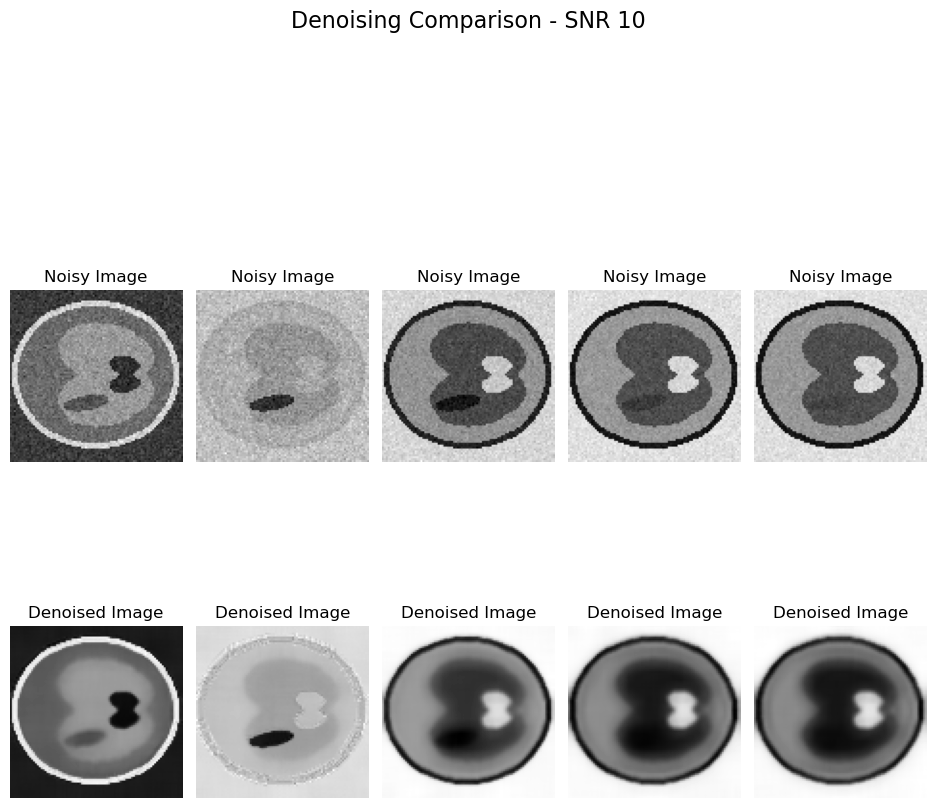

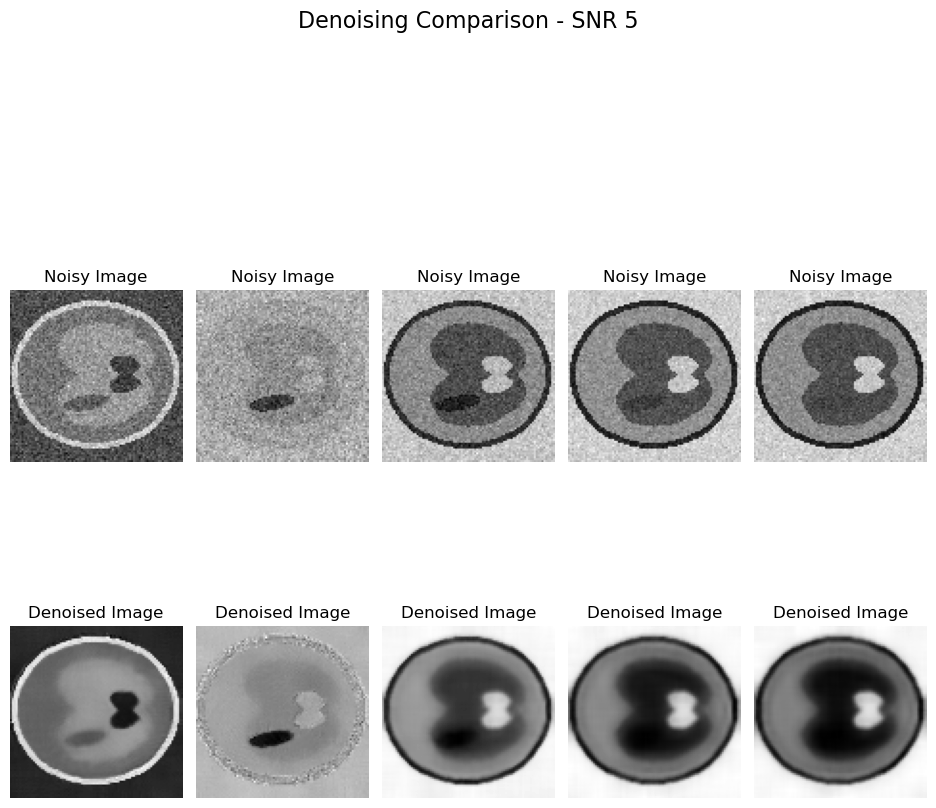

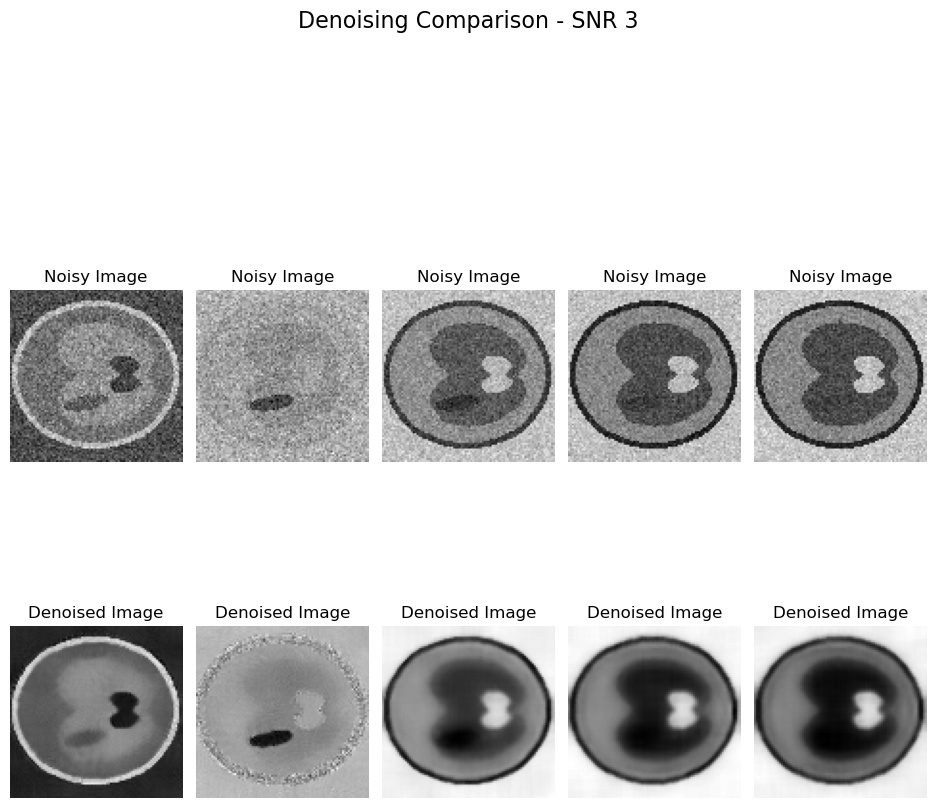

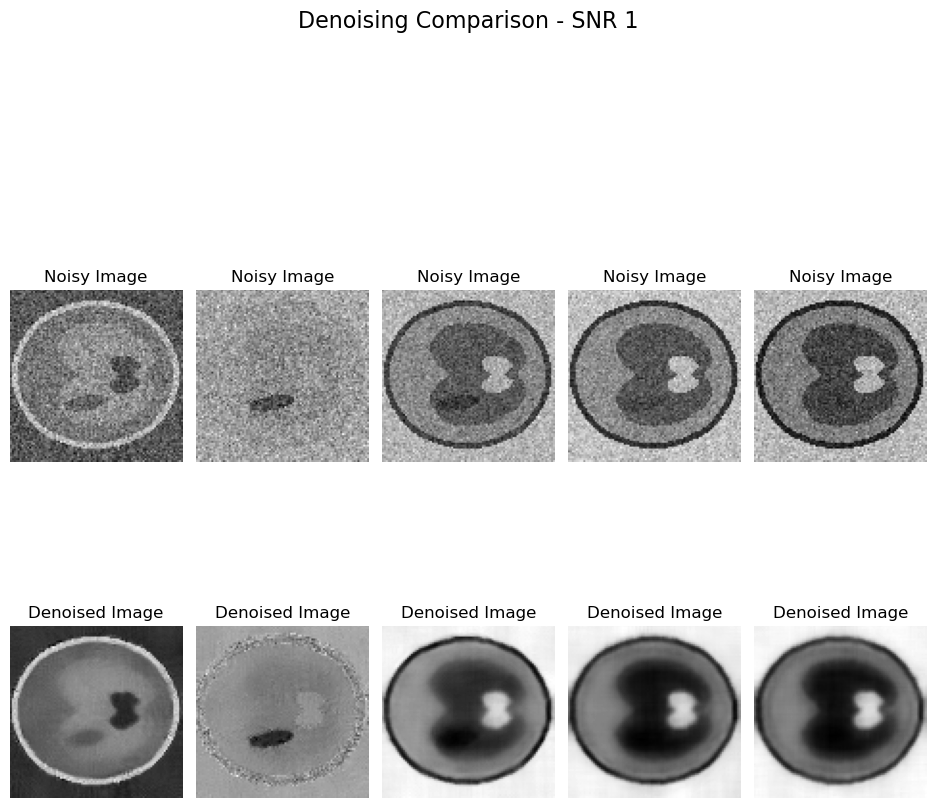

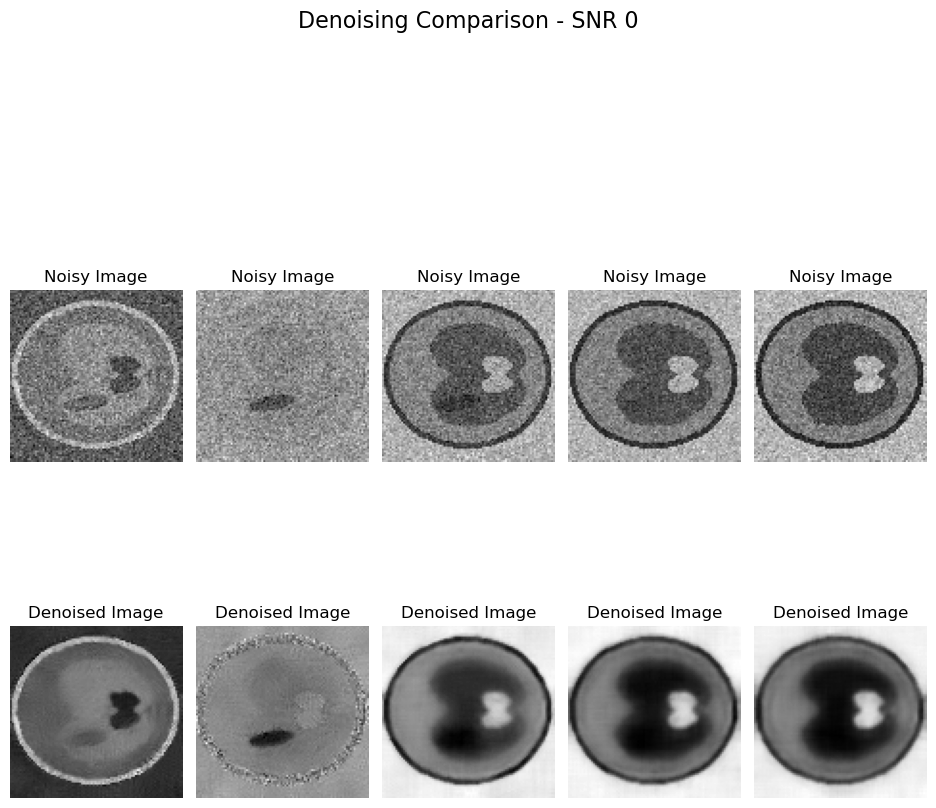

In [ ]:
import matplotlib.pyplot as plt
import scipy.io
import numpy as np

# Assuming `denoise_nl_means` is imported or defined elsewhere
# from somewhere import denoise_nl_means

# Define the specific SNRs to display
snrs = [10, 5, 3, 1, 0]

for snr in snrs:
    mat = scipy.io.loadmat(f'/Users/dolorious/Downloads/simulation-1/GroundTruth_rician_SNR{snr}.mat')
    noisy_image_data = mat['data_rician']
    conditions = noisy_image_data.shape[2]
    
    # Dynamically set up the figure for displaying images
    plt.figure(figsize=(10, 2 * conditions))

    for j in range(conditions):
        noisy_image = noisy_image_data[:, :, j]
        
        # Check if the image has three channels (RGB), and convert to grayscale if so
        if noisy_image.ndim == 3 and noisy_image.shape[2] == 3:
            noisy_image_gray = np.mean(noisy_image, axis=2)
        else:
            noisy_image_gray = noisy_image  # The image is already grayscale
        
        # Estimate the noise standard deviation using the noisy image
        sigma_est = np.std(noisy_image_gray)
        
        # Apply Non-Local Means Denoising with appropriate `multichannel` flag based on image type
        if noisy_image.ndim == 3 and noisy_image.shape[2] == 3:
            # For RGB images, keep `multichannel=True`
            denoised_image = denoise_nl_means(noisy_image, h=1.15 * sigma_est, fast_mode=True,
                                              patch_size=5, patch_distance=6, multichannel=True)
            # Convert denoised RGB to grayscale for consistent plotting
            denoised_image_gray = np.mean(denoised_image, axis=2)
        else:
            # For grayscale images, use `multichannel=False`
            denoised_image_gray = denoise_nl_means(noisy_image_gray, h=1.15 * sigma_est, fast_mode=True,
                                                   patch_size=5, patch_distance=6, multichannel=False)
        
        # Plot the original noisy image
        plt.subplot(2, conditions, j + 1)
        plt.imshow(noisy_image_gray, cmap='gray')
        plt.title('Noisy Image')
        plt.axis('off')

        # Plot the denoised image
        plt.subplot(2, conditions, j + conditions + 1)
        plt.imshow(denoised_image_gray, cmap='gray')  # Display denoised grayscale image
        plt.title('Denoised Image')
        plt.axis('off')

    plt.tight_layout(pad=3.0, h_pad=3.0, w_pad=1.0)
    plt.subplots_adjust(top=0.85)
    plt.suptitle(f'Denoising Comparison - SNR {snr}', fontsize=16, y=0.98)
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
from skimage.restoration import estimate_sigma, denoise_nl_means

# Define the specific SNRs to display
snrs = [5, 10, 20, 30, 40, 50]

# Iterate over each SNR
for snr in snrs:
    # Load the MAT file
    mat = scipy.io.loadmat(f'/Users/dolorious/Downloads/simulation-1/GroundTruth_rician_SNR{snr}.mat')

    # Extract noisy image data for the specified SNR
    noisy_image_data = mat['data_rician']

    conditions = noisy_image_data.shape[2]  # Assuming this represents different conditions.

    for j in range(conditions):
        # Extract the noisy image for the jth condition.
        noisy_image = noisy_image_data[:, :, j].squeeze()

        # Convert RGB image to grayscale
        noisy_image_gray = np.mean(noisy_image, axis=2)

        # Estimate the noise standard deviation from the grayscale image
        sigma_est = np.mean(estimate_sigma(noisy_image_gray))

        # Apply Non-Local Means Denoising
        denoised_image = denoise_nl_means(noisy_image_gray, h=1.15 * sigma_est, fast_mode=True,
                                          patch_size=5, patch_distance=6)

        # Normalize pixel values to the range [0, 1]
        denoised_image_normalized = denoised_image / 255.0

        # Save the denoised image
        filename = f'denoised_image_SNR_{snr}_Condition_{j+1}.png'
        plt.imsave(filename, denoised_image_normalized, cmap='gray')

        print(f'Saved {filename}')


Saved denoised_image_SNR_5_Condition_1.png
Saved denoised_image_SNR_5_Condition_2.png
Saved denoised_image_SNR_5_Condition_3.png
Saved denoised_image_SNR_5_Condition_4.png
Saved denoised_image_SNR_5_Condition_5.png
Saved denoised_image_SNR_10_Condition_1.png
Saved denoised_image_SNR_10_Condition_2.png
Saved denoised_image_SNR_10_Condition_3.png
Saved denoised_image_SNR_10_Condition_4.png
Saved denoised_image_SNR_10_Condition_5.png
Saved denoised_image_SNR_20_Condition_1.png
Saved denoised_image_SNR_20_Condition_2.png
Saved denoised_image_SNR_20_Condition_3.png
Saved denoised_image_SNR_20_Condition_4.png
Saved denoised_image_SNR_20_Condition_5.png
Saved denoised_image_SNR_30_Condition_1.png
Saved denoised_image_SNR_30_Condition_2.png
Saved denoised_image_SNR_30_Condition_3.png
Saved denoised_image_SNR_30_Condition_4.png
Saved denoised_image_SNR_30_Condition_5.png
Saved denoised_image_SNR_40_Condition_1.png
Saved denoised_image_SNR_40_Condition_2.png
Saved denoised_image_SNR_40_Condition